# News Analysis with LLM (Gemini)

In [1]:
import os
from dotenv import load_dotenv

load_dotenv("secret.env")

api_key = os.getenv("GEMINI_API_KEY")

if api_key is None:
    print("Error: GEMINI_API_KEY not found in .env file or environment variables.")
else:
    print("GEMINI_API_KEY loaded successfully.")

GEMINI_API_KEY loaded successfully.


In [2]:
import google.generativeai as genai
from tqdm import tqdm

genai.configure(api_key=api_key)
generation_config = genai.GenerationConfig(
        temperature=0,
)
model = genai.GenerativeModel("gemini-2.5-flash-preview-04-17", generation_config=generation_config)

In [3]:
from google.api_core import retry

# Catch transient Gemini errors.
def is_retryable(e) -> bool:
    if retry.if_transient_error(e):
        # Good practice, but probably won't fire with the google-genai SDK
        return True
    elif (isinstance(e, genai.errors.ClientError) and e.code == 429):
        # Catch 429 quota exceeded errors
        return True
    elif (isinstance(e, genai.errors.ServerError) and e.code == 503):
        # Catch 503 model overloaded errors
        return True
    else:
        return False

@retry.Retry(predicate=is_retryable)
def generate_content_with_rate_limit(prompt):
  return model.generate_content(prompt).text

In [4]:
prompt = """You are a financial news analyst specializing in stock market impact. Your task is to analyze the provided news article, summarize its core content concisely, determine its sentiment (positive, negative, or neutral), and assess its importance to the specified stock.

Here is the news from stock [STOCK] title and body:
---
[TITLE]
---
[BODY]
---

Please provide your analysis in the following format (Don't forget to make space between the sections as shown):

**Sentiment:**
[Positive / Negative / Neutral]

**Summary:**
[Your concise summary of the article, typically 2-3 sentences.]

**Reasoning for Sentiment:**
[Brief explanation (1-2 sentences) of why you categorized the sentiment as such, referencing key points or tone from the article.]

**Importance to Stock [STOCK]:**
[1-5, where 1 is minimal importance and 5 is very high importance.Answer in 1-5 only, no explanation.] (Answer only in number 1-5)

**Reasoning for Importance:**
[Brief explanation (1-2 sentences) of why you assigned this importance score, referencing specific details from the article that would impact the stock.]"""

In [5]:
import pandas as pd
import numpy as np

In [6]:
df = pd.read_csv("../../DataCollection/Data/Trending_News/2025-05-28_09-50-53.csv")
display(df.head())

,publish_date,publish_time,title,body_text,url
0,2025-05-27,20:39,"Trump says Golden Dome to cost Canada $61 bln,...",Investing.com-- U.S. President Donald Trump sa...,https://www.investing.com/news/economy-news/tr...
1,2025-05-27,20:35,Elon Musk must face lawsuit over his role in D...,Investing.com-- A federal judge said on Tuesda...,https://www.investing.com/news/economy-news/el...
2,2025-05-27,20:26,Circle Internet IPO multiple times oversubscri...,Investing.com-- Circle Internet is seeing stro...,https://www.investing.com/news/stock-market-ne...
3,2025-05-27,20:07,US stock futures steady with Nvidia earnings i...,Investing.com-- U.S. stock index futures rose ...,https://www.investing.com/news/stock-market-ne...
4,2025-05-27,19:51,Japan offers to buy US chips as part of tariff...,Investing.com-- Japan has proposed purchasing ...,https://www.investing.com/news/stock-market-ne...


In [7]:
df.isnull().sum()

publish_date    0
publish_time    0
title           0
body_text       0
url             0
dtype: int64

In [8]:
df["title"] = df["title"].astype(str)
df["body_text"] = df["body_text"].astype(str)

In [9]:
print(df.head())

  publish_date publish_time  \
0   2025-05-27        20:39   
1   2025-05-27        20:35   
2   2025-05-27        20:26   
3   2025-05-27        20:07   
4   2025-05-27        19:51   

                                               title  \
0  Trump says Golden Dome to cost Canada $61 bln,...   
1  Elon Musk must face lawsuit over his role in D...   
2  Circle Internet IPO multiple times oversubscri...   
3  US stock futures steady with Nvidia earnings i...   
4  Japan offers to buy US chips as part of tariff...   

                                           body_text  \
0  Investing.com-- U.S. President Donald Trump sa...   
1  Investing.com-- A federal judge said on Tuesda...   
2  Investing.com-- Circle Internet is seeing stro...   
3  Investing.com-- U.S. stock index futures rose ...   
4  Investing.com-- Japan has proposed purchasing ...   

                                                 url  
0  https://www.investing.com/news/economy-news/tr...  
1  https://www.investing.com/

In [10]:
predicted = []

for index, row in tqdm(df.iterrows(), total=len(df), desc="Prompting"): 
    current_stock = row.get("ticker", "news")

    filled_prompt = prompt.replace("[STOCK]", current_stock)
    filled_prompt = filled_prompt.replace("[TITLE]", row["title"])
    filled_prompt = filled_prompt.replace("[BODY]", row["body_text"])

    try:
        response = generate_content_with_rate_limit(filled_prompt)
        finalprediction = response.strip()
        if not finalprediction:
            print(f"Row {index}: LLM returned an empty string.")
            predicted.append("LLM_EMPTY_RESPONSE")
        else:
            predicted.append(finalprediction)
    except ValueError as ve:
        print(f"Row {index}: ValueError - {ve}. Appending 'ERROR_VALUE_ERROR'.")
        predicted.append("ERROR_VALUE_ERROR")
        continue
    except Exception as e:
        if "429 Too Many Requests" in str(e) or "quota" in str(e).lower():
            print(f"Row {index}: Rate Limit Exceeded or Quota Error - {e}. Appending 'ERROR_RATE_LIMIT'.")
            predicted.append("ERROR_RATE_LIMIT")
        elif "safety" in str(e).lower() or "blocked" in str(e).lower():
             print(f"Row {index}: Content Safety/Blocked - {e}. Appending 'ERROR_SAFETY_BLOCKED'.")
             predicted.append("ERROR_SAFETY_BLOCKED")
        else:
            print(f"Row {index}: Unexpected Error - {e}. Appending 'ERROR_UNEXPECTED'.")
            predicted.append("ERROR_UNEXPECTED")
        continue

Prompting: 100%|██████████| 20/20 [01:49<00:00,  5.48s/it]


In [11]:
predicted = np.array(predicted)
df["predicted"] = predicted

In [12]:
print(df["title"][2],'\n\n',predicted[2])

Circle Internet IPO multiple times oversubscribed- Bloomberg By Investing.com 

 **Sentiment:**
Positive

**Summary:**
Circle Internet's initial public offering is reportedly multiple times oversubscribed, indicating strong investor demand. This strong interest is occurring amidst improving sentiment in the crypto market, partly driven by hopes for more favorable U.S. regulation and progress on a stablecoin bill.

**Reasoning for Sentiment:**
The primary reason for the positive sentiment is the news that the IPO is "multiple times oversubscribed," which signifies high investor confidence and demand for Circle's shares. The article also highlights the positive backdrop of improving crypto sentiment and potential regulatory clarity.

**Importance to Stock news:**
5

**Reasoning for Importance:**
An oversubscribed IPO is a critical milestone for a company going public, indicating strong market reception and potentially influencing the final pricing. For Circle, a major player in the stabl

In [13]:
df["sentiment"] = df["predicted"].apply(lambda x: x.split("\n")[1].strip() if len(x.split("\n")) > 1 else None)
df["importance"] = df["predicted"].apply(lambda x: x.split("\n")[10].strip() if len(x.split("\n")) > 10 else None)
df["summary"] = df["predicted"].apply(lambda x: x.split("\n")[4].strip() if len(x.split("\n")) > 4 else None)

In [14]:
df[df["importance"]== "5"][["publish_date","title", "sentiment","importance", "summary"]]

,publish_date,title,sentiment,importance,summary
2,2025-05-27,Circle Internet IPO multiple times oversubscri...,Positive,5,Circle Internet's initial public offering is r...
3,2025-05-27,US stock futures steady with Nvidia earnings i...,Positive,5,"US stock futures edged slightly higher, with m..."
4,2025-05-27,Japan offers to buy US chips as part of tariff...,Positive,5,Japan has proposed purchasing billions of doll...
5,2025-05-27,"Trump says working on taking Fannie Mae, Fredd...",Positive,5,President Trump announced he is actively worki...
6,2025-05-27,Nvidia suppliers ramp up AI server production ...,Positive,5,Nvidia's key suppliers have successfully resol...
8,2025-05-27,JPM highlights top 6 European investment ideas...,Positive,5,JPMorgan has outlined its top six European inv...
9,2025-05-27,"Next 300 points likely up for the S&P 500, say...",Positive,5,JPMorgan analysts predict the S&P 500's next m...
11,2025-05-27,New surveys show declining interest in EVs and...,Negative,5,New surveys from UBS and Stifel indicate a sig...
12,2025-05-27,StanChart sees Solana price rising over 50% by...,Positive,5,Standard Chartered has initiated coverage on S...
13,2025-05-27,Citi sees up to 8% downside for Stoxx 600 on T...,Negative,5,Citi analysts warn that the Stoxx 600 index co...


In [15]:
display(df[df['sentiment']==''])
df = df[df['sentiment'] != '']

,publish_date,publish_time,title,body_text,url,predicted,sentiment,importance,summary


In [16]:
df = df[df['sentiment'].isin(['Positive', 'Negative', 'Neutral'])]
df = df[df['importance'].isin(['1', '2', '3', '4', '5'])]

<Axes: title={'center': 'Sentiment Distribution'}, xlabel='sentiment'>

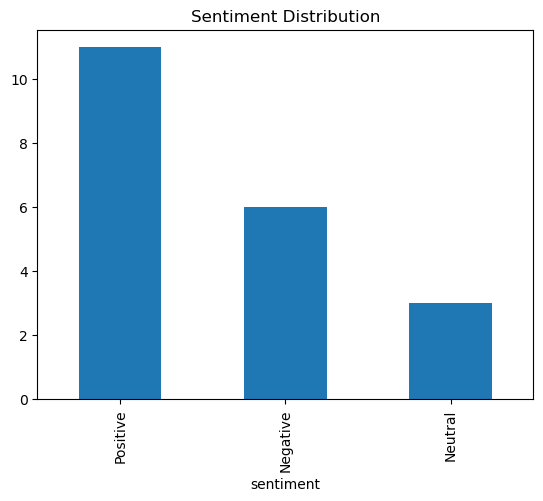

In [17]:
df['sentiment'].value_counts().plot(kind='bar', title='Sentiment Distribution')

<Axes: title={'center': 'Importance Distribution'}, xlabel='importance'>

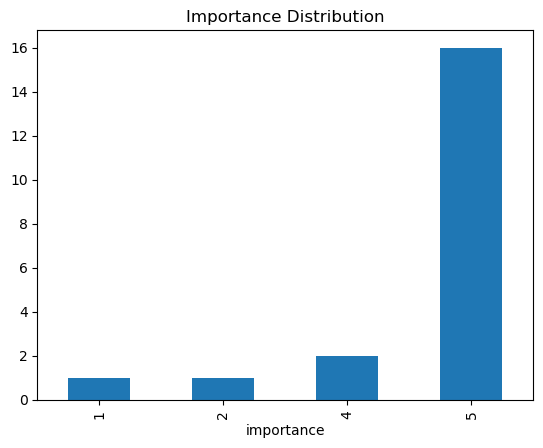

In [18]:
df['importance'].value_counts().sort_index().plot(kind='bar', title='Importance Distribution')

In [19]:
TICKER=current_stock

In [20]:
df[df['sentiment']=='']
df = df[df['sentiment'] != '']

In [21]:
def calculate_sentiment_score(df):
    sentiment_scores = {
        'Positive': 1,
        'Negative': -1,
        'Neutral': 0
    }
    
    df['sentiment_score'] = df['sentiment'].map(sentiment_scores)
    
    df['weighted_score'] = df['sentiment_score'] * df['importance'].astype(int)
    
    total_importance = df['importance'].astype(int).sum()
    
    if total_importance == 0:
        return 0
    
    sentiment_score = df['weighted_score'].sum() / total_importance
    return sentiment_score

In [22]:
print(f"Sentiment Score for {TICKER}: {calculate_sentiment_score(df).round(2)}")

Sentiment Score for news: 0.31


In [23]:
import datetime

df.drop(columns=['predicted','body_text'],inplace=True)
now = datetime.datetime.now()
date_time = now.strftime("%Y-%m-%d %H-%M-%S").strip().replace(' ', '_')
df.to_csv(f"Output/Gemini/Gemini_{TICKER}_{date_time}.csv", index=False)